# Importing needed libraries

In [2]:
#pip install statsmodels scikit_posthocs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 986.6 kB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 1.4 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
#!pip install scikit-posthocs

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import numpy as np
from scipy.stats import shapiro
from scipy.stats import levene
from scipy.stats import kruskal
import scikit_posthocs as sp

#plt.style.use('seaborn-darkgrid')
sns.set_context('notebook')

# Reading tables

In [4]:
# Reading CSV files
label_table = pd.read_csv("label_dataset.csv", usecols=lambda column: column != 'Unnamed: 0')
print(label_table.dtypes)  

commits_with_git_url = pd.read_csv("commits_with_git_url.csv", usecols=lambda column: column != 'Unnamed: 0')
print(commits_with_git_url.dtypes)

# Joining dataframes
commits_label = pd.merge(commits_with_git_url, label_table, on="repo_id", how="inner")
print(commits_label.dtypes)

# Selecting specific columns
commitSelectedVar = commits_label[['repo_id', 'commits', 'label_name']]

repo_id        int64
label_name    object
dtype: object
rg_name          object
repo_group_id     int64
repo_name        object
repo_id           int64
repo_git         object
forked_from      object
repo_archived     int64
commits           int64
dtype: object
rg_name          object
repo_group_id     int64
repo_name        object
repo_id           int64
repo_git         object
forked_from      object
repo_archived     int64
commits           int64
label_name       object
dtype: object


# General visualization
## Excluding outliers

In [5]:
# Exclude outliers
def exclude_outliers(data, variable, group_var, sd_threshold=2):
    # Function to filter outliers in a group
    def filter_group(group):
        mean_val = group[variable].mean()
        sd_val = group[variable].std()
        return group[np.abs(group[variable] - mean_val) < sd_threshold * sd_val]
    
    # Apply the filter function to each group and combine the results
    return data.groupby(group_var).apply(filter_group).reset_index(drop=True)

In [6]:
commitSelectedVar_filtered = exclude_outliers(commitSelectedVar, "commits", "label_name", sd_threshold=2)

/var/folders/rl/lb0rdx9d4zs_bbk87y3zw1kw0000gn/T/ipykernel_89275/1596213973.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return data.groupby(group_var).apply(filter_group).reset_index(drop=True)


## Calculating descriptive stats showing on the plot 

In [7]:
# Calculate stats to show on the plot
stats_df = commitSelectedVar_filtered.groupby('label_name')['commits'].agg(
    average='mean',
    upper_quartile=lambda x: x.quantile(0.75)
).reset_index()

stats_df['label_pos'] = stats_df['upper_quartile'] + 0.5

## Generating box plot

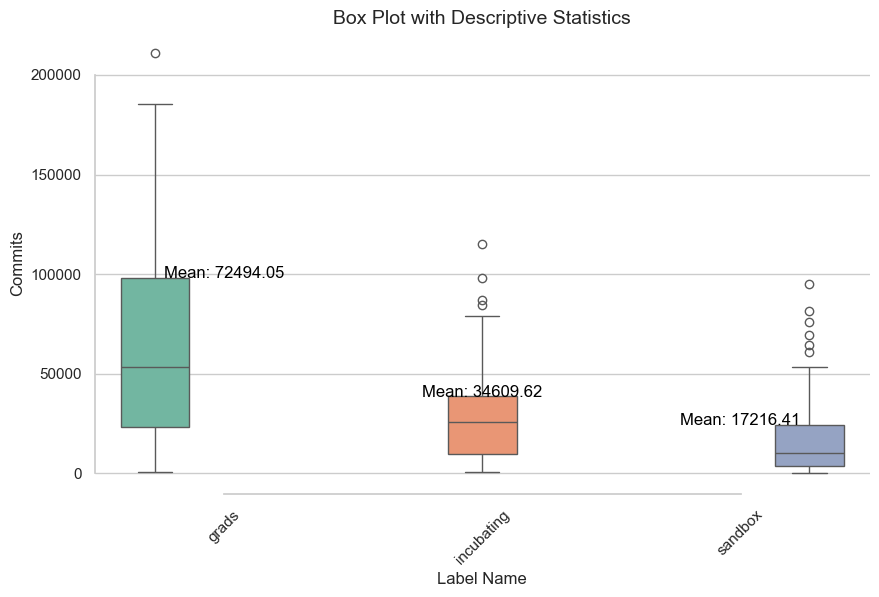

In [12]:
# Set plots style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# Create a boxplot
ax = sns.boxplot(x='label_name', y='commits', data=commitSelectedVar_filtered, palette="Set2", dodge=True, hue="label_name")

# Add mean values as text on the plot
for index, row in stats_df.iterrows():
    ax.text(
        x=index, 
        y=row['label_pos'], 
        s=f"Mean: {row['average']:.2f}", 
        color='black', 
        ha="center", 
        size=12
    )

# Set plot title and labels
ax.set_title('Box Plot with Descriptive Statistics', fontsize=14)
ax.set_xlabel('Label Name', fontsize=12)
ax.set_ylabel('Commits', fontsize=12)

# Making plot easier to read
sns.despine(trim=True)
plt.xticks(rotation=45)

plt.show()

# Start testing normality and variance homogeneous
## Distribution visualization

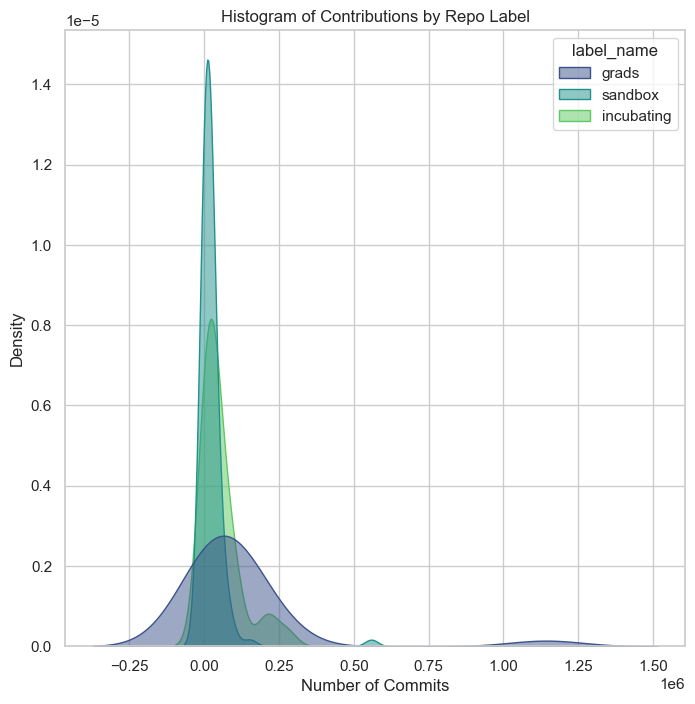

In [16]:
# Create a density plot
plt.figure(figsize=(8, 8))
#sns.kdeplot(data=commitSelectedVar, x='commits', hue='label_name', fill=True, common_norm=False, alpha=0.5, palette='coolwarm')
sns.kdeplot(data=commitSelectedVar, x='commits', hue='label_name', fill=True, common_norm=False, alpha=0.5, palette='viridis')

plt.title('Histogram of Contributions by Repo Label')
plt.xlabel('Number of Commits')
plt.ylabel('Density')
plt.show()

## Q-Q plot visualization to check whether the variable follows normal distribution

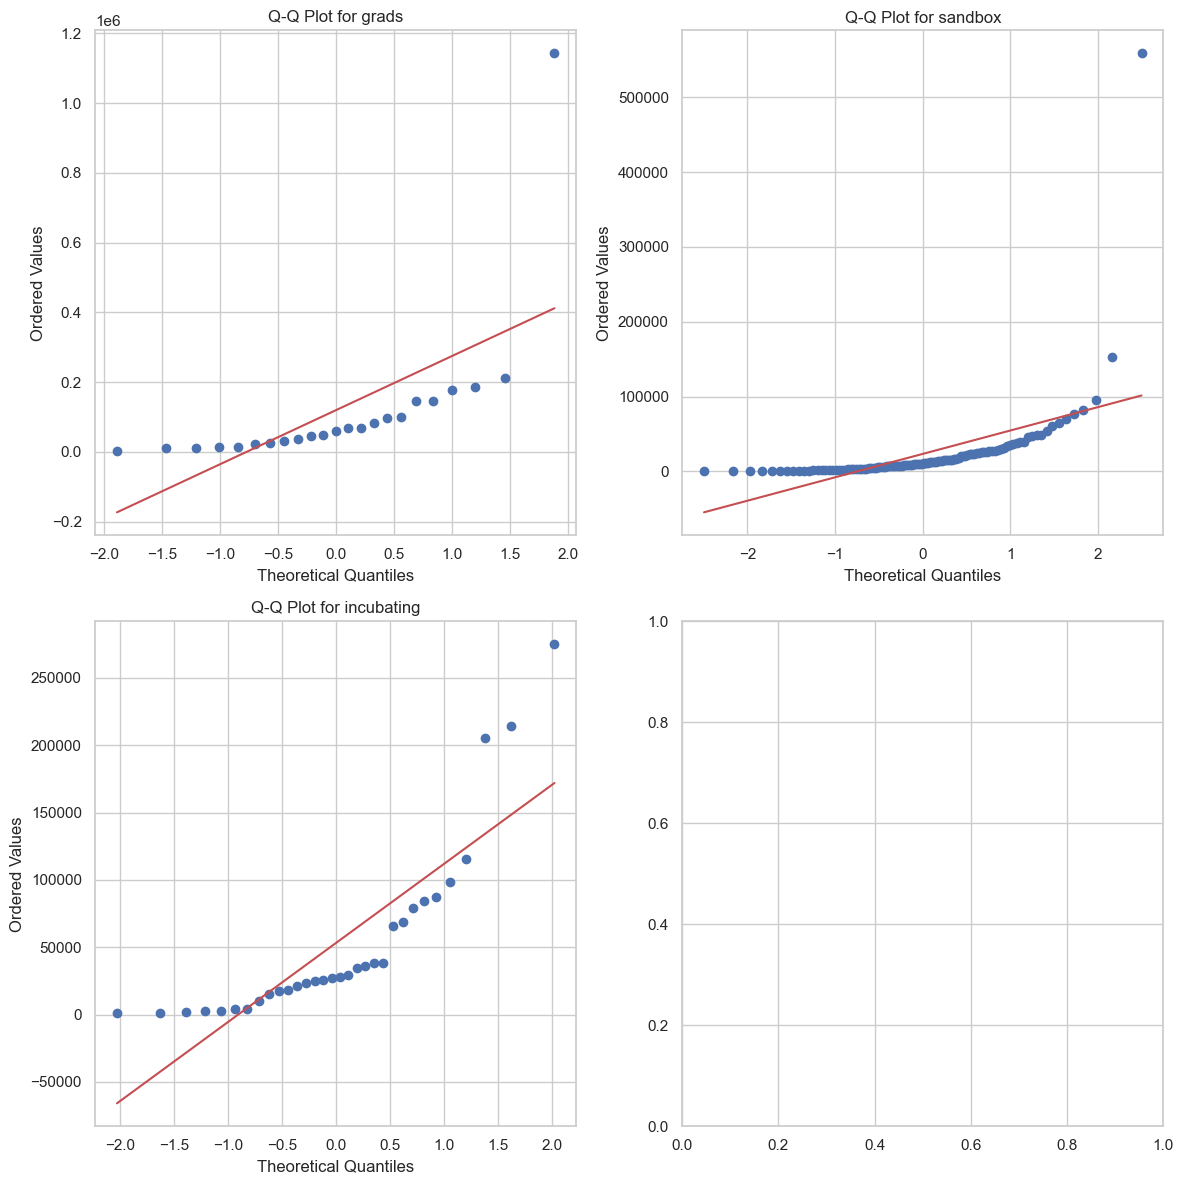

In [17]:
# Define the unique groups
unique_labels = commitSelectedVar['label_name'].unique()

# Setup the figure to plot: Q-Q plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axes = axes.flatten()

for i, label in enumerate(unique_labels):
    data = commitSelectedVar[commitSelectedVar['label_name'] == label]['commits']
    stats.probplot(data, dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q Plot for {label}')
    axes[i].set_xlabel('Theoretical Quantiles')
    axes[i].set_ylabel('Ordered Values')

plt.tight_layout()
plt.show()

## Shapiro-Wilk Test to test wether the variable per group follows normal distribution

In [15]:
# Shapiro-Wilk test for each group
shapiro_results = commitSelectedVar.groupby('label_name')['commits'].apply(lambda x: shapiro(x))
print(shapiro_results)

label_name
grads          (0.4417046932020371, 2.487832264343384e-08)
incubating        (0.7288588831870808, 2.419226646196e-06)
sandbox       (0.3172944943933784, 2.3924124210386658e-20)
Name: commits, dtype: object


No group's commit number follows normal distribution.

## Levene's test to test whether the variance per group is homogeneous

In [18]:
# Prepare the data for Levene's test
groups = [group['commits'].values for name, group in commitSelectedVar.groupby('label_name')]

# Perform Levene's test
stat, p = levene(*groups, center='median')
print(f'Levene’s Test Statistic: {stat}, P-value: {p}')


## If the three groups had similar variance ... if the result were 1.0, the groups would be perfectly homogeneous 

Levene’s Test Statistic: 5.917452404352925, P-value: 0.0033084186905934475


No homogeneous variance found among groups. Combined with the testing results above, we decided to use Kruskal-Wallis H test along with Dunn's test to examine wehther the difference between each pair of group is significant.

## Kruskal-Wallis H test to test whether there is a significant difference among pairs of groups

In [19]:
# Preparing data for Kruskal-Wallis H Test
# Do the differences in commits between groups mean ANYTHING? Or is this not a potential feature? 
groups = [group['commits'].values for name, group in commitSelectedVar.groupby('label_name')]

# Perform Kruskal-Wallis H Test
stat, p = kruskal(*groups)
print(f'Kruskal-Wallis H Test Statistic: {stat}, P-value: {p}')

## This is a general test. The conclusion can only tell us there is a difference,
## but will not tell us which pairs among the 3 groups have significant differences.
## This leads us to the post-hoc test next.
## Need to look into the interpretation of the raw stat, however this result suggests
## There IS a significant difference. The next test clarifies how differentiating
## The commits data is between different groups pairwise


Kruskal-Wallis H Test Statistic: 28.66850183342069, P-value: 5.952699024385435e-07


## Dunn's test to conduct post-hoc test for examining the differience between each pair of groups.

In [20]:
# Conduct Dunn's Test
dunn_test_result = sp.posthoc_dunn(commitSelectedVar, val_col='commits', group_col='label_name', p_adjust='fdr_bh')

print(dunn_test_result)

               grads  incubating   sandbox
grads       1.000000    0.099845  0.000004
incubating  0.099845    1.000000  0.001714
sandbox     0.000004    0.001714  1.000000


# Summary
The number of commits is a good feature to distinguish between the pair of group of grads vs. sandbox as well as incubating vs. sandbox. However, the power of it to distinguish between the grads and incubating groups is not significantly strong. We may need to add other features, individually or go together with the feature of commit number, to distinguish groups between grads and incubating.

Next steps: 
- Issues
- Pull Requests
- Pull Request Reviews (but I am not sure it will be necessary "next")




Finer grained analysis: 
- pull requests accepted v pull requests not accepted (whether or not they are merged)
- contributor totals 
- releases


